In [1]:
using Plots
include("polyfit_function.jl")
include("Lagrange_interpolation.jl")
include("LReg.jl")

LReg (generic function with 1 method)

In [3]:
# Reference Solution (Implicit) for u'=lambda*u

function refimp(f, a, b, u0, lambda, N)
    dt=(b-a)/N
    t=(0:N)*dt
    m=2
    DT=m*dt
    U=zeros(1, N+1, 2)
    U[1, 1, 1]=u0
    U[1, 1, 2]=u0
    for i=1:m:N

        U[1, i, 1]=U[1, i, 2]
        
        for j=i:i+1
            U[1, j+1, 1]= U[1, j, 1]/(1-dt*lambda)
        end
           
        #U[1, i+m, 2]= (U[1, i, 2]- DT*lambda*U[1, i+m, 1] + Lagrange(t[i:i+2], f(t[i:i+2], U[1, i:i+2, 1]), t[i], t[i+2]))/(1-DT*lambda)

        U[1, i+m, 2]= (U[1, i, 2]- DT*lambda*U[1, i+m, 1] + (DT/6)*lambda*U[1, i, 1]+(2*DT/3)*lambda*U[1, i+1, 1]+(DT/6)*lambda*U[1, i+m, 1])/(1-DT*lambda)
        
        # Trapezoidal
        #U[1, i+m, 2]= U[1, i, 2]+ DT*(f(t[i], U[1, i, 2])-f(t[i], U[1, i, 1])) + DT*0.5*(f(t[i], U[1, i, 1])+f(t[i+2], U[1, i+2, 1]))
    end
        
    return  U, t
end

refimp (generic function with 1 method)

convergence order = 2.0561039933712824


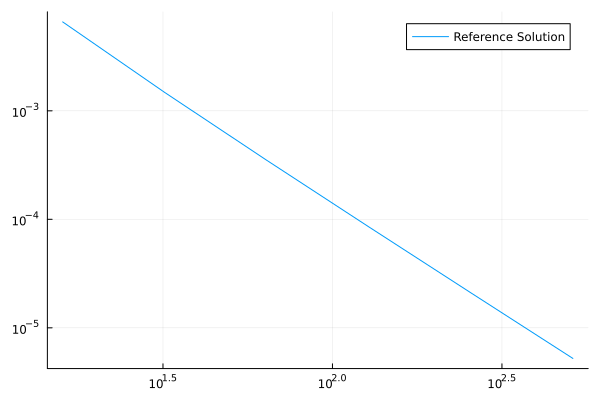

In [5]:
# Convergence test
using LinearAlgebra

u0 = 1.0
lambda= 1.0
f(t, u)= lambda* u
a=0
b=1.0
K = 6
err = zeros(K, 1)
ns=zeros(K, 1)
m=2

for k in 1:K
    
    N = 8*2^k
    
    ns[k]=N
    U, t= refimp(f, a, b, u0, lambda, N)
    exact= u0*exp.(lambda .* t)
    err[k] = norm(exact[1:m:end] .- U[1, 1:m:end, 2], Inf)
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:], xaxis=:log, yaxis=:log, label="Reference Solution")
display(plot!(legend=:topright))

In [7]:
function twolevel(f, a, b, N, u0, lambda, m, K)
    dt = (b - a)/ N 
    DT = m*dt
    u = zeros(1, N + 1, K + 1)
    u[1, 1, 1] = u0
    ps = 3:m:N
    u[1, ps, 1] = ones(length(ps)) # initializing random values
    t = (0:N)*dt
    up = zeros(N + 1)
    up[1] = u0

    for k in 1:K
        
        u[1, 1, k + 1] = u0

        #coarsening factor 4

        # F-Relaxation
        for i=1:m:N
            up[i]=u[1, i, k] # injection from the second level
            up[i+1]=up[i]/(1-dt*lambda)
        end

        # C-Relaxation
        for j=2:m:N
            up[j+1]=up[j]/(1-dt*lambda)
        end

        # Coarse Grid Correction
        for n =1:m:N
            up[n]=u[1, n, k] 
            
            #u[1, n+m, k+1] = (u[1, n, k+1] - DT*lambda*up[n+m] + Lagrange(t[n:n+m], f(t[n:n+m], up[n:n+m]), t[n], t[n+m]))/(1-lambda*DT)
            u[1, n+m, k+1] = (u[1, n, k+1] - DT*lambda*up[n+m] + lambda*DT*((1/6)* up[n]+(2/3)* up[n+1]+(1/6)*up[n+m]))/(1-lambda*DT)

            # Trapezoidal
            #u[1, n+m, k+1] = u[1, n, k+1] + DT*(f(t[n], u[1, n, k+1]) - f(t[n], u[1, n, k])) + DT*0.5*(f(t[n], up[n])+f(t[n+m], up[n+m]))
        end
    end

    return t, u
end

twolevel (generic function with 1 method)

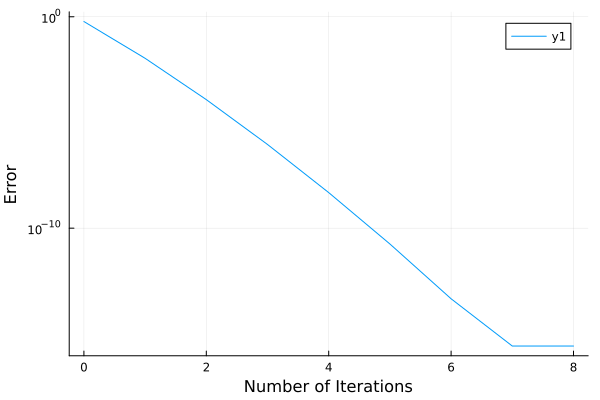

In [9]:
using LinearAlgebra, Plots

u0 = 1.0
a = 0
b = 1.0
lambda= -1.0
f(t, u) = lambda*u
N = 20
K = 8 # Number of Iterations
m = 2
err=zeros(K+1)
tval, u= twolevel(f, a, b, N, u0, lambda, m, K) # Approximate Solution
U, t = refimp(f, a, b, u0, lambda, N) # Reference Solution
for k=1:K+1
    err[k]= norm(U[1, 1:m:end, 2] .- u[1, 1:m:end, k], Inf) .+10^(-16)
end
plot(0:K, err, yaxis=:log, xlabel="Number of Iterations", ylabel="Error")

# Checking the all-at-once system for the reference solution defined as Au=b

We are solving the ODE
\begin{align}
\frac{du}{dt}= \lambda u,  \quad u(0)=a \quad, t\in[0, 1]
\end{align}

The all-at-once for the two-level IDC with the associated quadrature weights can be defined as \begin{align}\tilde{A}u=b\end{align}

where 
\begin{align}
\tilde{A} = \begin{bmatrix}
1 &  &  &  &  \\
-1+ \tilde{\beta} & \alpha &  &  &  \\
& -1+ \tilde{\beta} & \alpha &  &  \\
&  & \ddots & \ddots &  \\
&  &  & -1+\tilde{\beta} & \alpha \\
\end{bmatrix}, \qquad
b=\begin{bmatrix}
a \\
0 \\
0 \\
\vdots \\
0 \\
\end{bmatrix}
\end{align}
with 
\begin{align}
\alpha &= (1 - \Delta T), \quad \beta =  \Delta T \left(-\frac{5}{6(1 - \Delta t)^2} + \frac{2}{3(1 - \Delta t)} + \frac{1}{6} \right), \quad \tilde{\beta} = -\beta
\end{align}

In [11]:
# All-at-once-Matrix system for the reference solution \tilde{A}U=b

function Mref(N, m, u0, lambda)
Nc= div(N, m) # number of coarse points
dt=1/N
DT=2*dt
alpha=(1-lambda* DT)
beta = -1 + lambda*DT*((5/6) * 1/(1-lambda*dt).^2 - (2/3)* 1/(1-lambda*dt) - 1/6)
A=Bidiagonal([1; fill(alpha, Nc)], fill(beta, Nc), :L)
b=zeros(Nc+1)
b[1]=u0
u=zeros(Nc+1)
u=A\b
return u
end

Mref (generic function with 1 method)

We can decompose the matrix \begin{align}\tilde{A}=A-L\end{align}

In [13]:
# Reference solution in AU=b+LU

function MLin(N, m, u0, lambda)
    Nc = div(N, m)  # number of coarse points
    dt = 1 / N
    DT = 2 * dt
    alpha = (1 - lambda*DT)
    beta =  beta = lambda*DT*(-(5/6) * 1/(1-lambda*dt).^2 + (2/3)* 1/(1-lambda*dt) + 1/6)

    # Original matrix A as a bidiagonal matrix
   
    # Decompose \tilde{A} into A - L
    A = Bidiagonal([1; fill(alpha, Nc)], fill(-1.0, Nc), :L)
    L = Bidiagonal([0; fill(0.0, Nc)], fill(beta, Nc), :L)

    # Initialize vectors b and u
    b = zeros(Nc + 1)
    b[1] = u0
    u = zeros(Nc + 1)
    vk=ones(Nc+1)
    u[1]= u0
    # Solve the system using the decomposed matrices
    for i=1:Nc+1
        u = A \ b + (A \ L) * vk
        vk=u
    end

    return u
end

MLin (generic function with 1 method)

# Let's check the approximate solution as our structured matrix form

The idea is to write the iterative two-level deferred correction scheme into the form

\begin{align}
Au^{k}=b+Lu^{k-1}
\end{align}
with

\begin{align}
A = \begin{bmatrix}
1 &  &  &  &  \\
-1 & \alpha &  &  &  \\
& -1 & \alpha &  &  \\
&  & \ddots & \ddots &  \\
&  &  & -1 & \alpha \\
\end{bmatrix}, \qquad
b=\begin{bmatrix}
1 \\
0 \\
0 \\
\vdots \\
0 \\
\end{bmatrix}, \quad
L = \begin{bmatrix}
0 &  &  &  &  \\
\beta & 0 &  &  &  \\
& \beta & 0&  &  \\
&  & \ddots & \ddots &  \\
&  &  & \beta & 0 \\
\end{bmatrix}
\end{align}
where 
\begin{align}
\alpha=(1-\Delta T), \quad \beta= \lambda\Delta T\left( - \frac{5}{6(1-\Delta t)^2} + \frac{2}{3(1-\Delta t)} + \frac{1}{6} \right)
\end{align}

In [15]:
# all-at-once approximate solution

function Mappr(N, m, u0, lambda, K)
Nc= div(N, m) # number of coarse points
dt=1/N
DT=2*dt
alpha=(1-lambda*DT)
beta = lambda*DT*(-(5/6) * 1/(1-lambda*dt).^2 + (2/3)* 1/(1-lambda*dt) + 1/6)

A=Bidiagonal([1; fill(alpha, Nc)], fill(-1.0, Nc), :L)
L=Bidiagonal([0; fill(0.0, Nc)], fill(beta, Nc), :L)
b=zeros(Nc+1)
b[1]=u0
v=zeros(Nc+1)
vk=ones(Nc+1)

for i in 1:K
    v = A \ b + (A \ L) * vk
    vk = v  # Update vk for the next iteration
end
return v
end

Mappr (generic function with 1 method)

In [ ]:
# Comparision of all-at-once-matrix for reference, all-at-once matrix for reference, and numerical solution

u0 = 1.0
a = 0
b = 1.0
f(t, u) = u
N = 20
K = 8 # Number of Iterations
m = 2
lambda=1.0
# all-at-once reference solution Au=b
u1=Mref(N, m,u0, lambda)

# Numerical reference solution
u2, t= refimp(f, a, b, u0, lambda, N)

# Approximate solution (Numerical)

tval, u3= twolevel(f, a, b, N, u0, lambda, m, K)

# Approximate Solution in our structured matrix form

u4=Mappr(N, m, u0, lambda, K)

u5=MLin(N, m,u0, lambda)
#norm(u3[:, 1:2:end, 9]-u4)
norm(u1 .- u3[1, 1:2:end, 9])

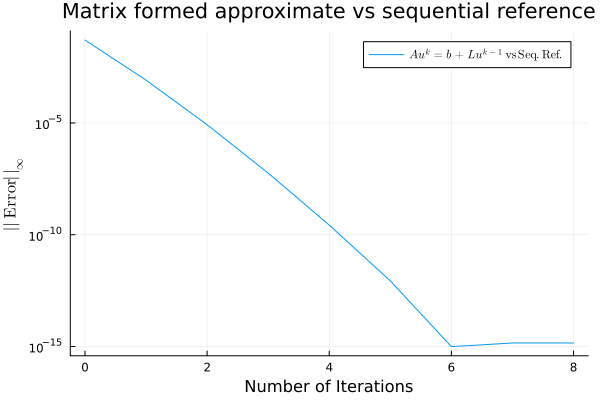

In [23]:
# Comparision with structured matrix form and approximated numerical solution
using LinearAlgebra, Plots, LaTeXStrings

u0 = 1.0
a = 0
b = 1.0
lambda= 1.0
f(t, u) = lambda*u
N = 20
K = 8 # Number of Iterations
m = 2
Nc=div(N, m)
err=zeros(K+1)
u_store=zeros(Nc+1, K+1)
U, t = refimp(f, a, b, u0, lambda, N) # Reference Solution
for k=1:K+1
    u_store[:, k]=Mappr(N, m, u0, lambda, k)
    err[k]= norm(u_store[:, k] .- U[1, 1:m:end, 2], Inf) .+10^(-16)
end

p1=plot(
    0:K, err, 
    yaxis=:log, 
    xlabel="Number of Iterations", 
    ylabel=L"||\mathrm{Error}||_\infty", 
    title="Matrix formed approximate vs sequential reference", 
    label = L"A u^k = b + L u^{k-1} \, \mathrm{vs} \, \mathrm{Seq. Ref.}"
)
savefig("Mapprox_vs_Sequential.png")
# Display the plot
display(p1)

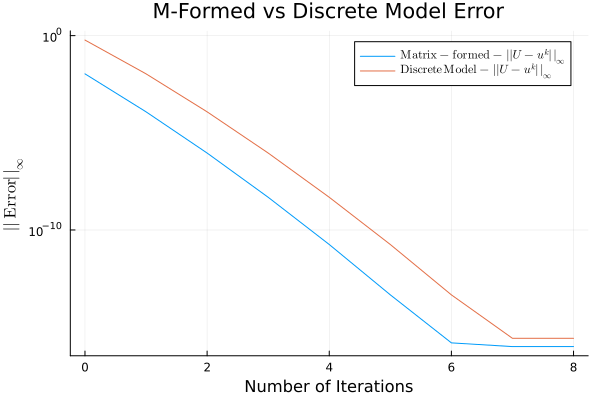

In [17]:
# Comparision with structured matrix form and approximated numerical solution
using LinearAlgebra, Plots, LaTeXStrings

u0 = 1.0
a = 0
b = 1.0
lambda= -1.0
f(t, u) = lambda*u
N = 20
K = 8 # Number of Iterations
m = 2
Nc=div(N, m)
err1=zeros(K+1)
err2=zeros(K+1)
Uref=MLin(N, m, u0, lambda)
u_store=zeros(Nc+1, K+1)
tval, uap=twolevel(f, a, b, N, u0, lambda, m, K)
U, t = refimp(f, a, b, u0, lambda, N) # Reference Solution
for k=1:K+1
    u_store[:, k]=Mappr(N, m, u0, lambda, k)
    err1[k]= norm(u_store[:, k] .- Uref, Inf) .+10^(-16)
    err2[k]= norm(U[1, 1:m:end, 2] .- uap[1, 1:m:end, k], Inf) .+10^(-16)
    
end
plot(0:K, err1, 
    yaxis=:log, xlabel="Number of Iterations", 
    ylabel=L"||\mathrm{Error}||_\infty",
    title="M-Formed vs Discrete Model Error", 
    label=L"\mathrm{Matrix-formed-}\, ||U-u^k||_\infty"
)
plot!(0:K, err2,

    label=L"\mathrm{Discrete \, Model-}\, ||U-u^k||_\infty"
)

savefig("M-error_vs_Discrete-model-error2.png")
# Display the plot
display(plot!(legend=:topright))

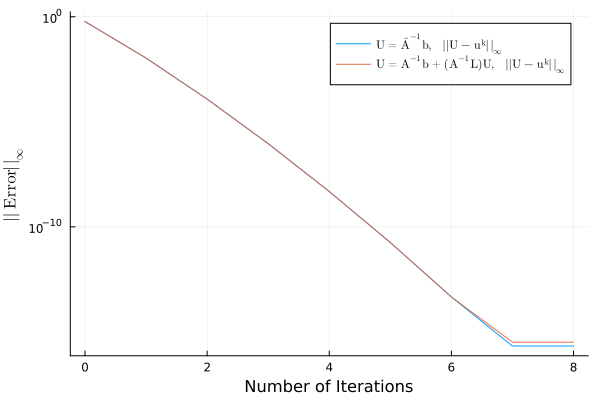

In [19]:
# Comparision with structured matrix form and approximated numerical solution
using LinearAlgebra, Plots, LaTeXStrings

u0 = 1.0
a = 0
b = 1.0
lambda= -1.0
f(t, u) = lambda*u
N = 20
K = 8 # Number of Iterations
m = 2
Nc=div(N, m)
err1=zeros(K+1)
err2=zeros(K+1)
dt=1/N
t=(0:N)*dt
Uref1=MLin(N, m, u0, lambda)
Uref2=Mref(N, m, u0, lambda)
tval, uap=twolevel(f, a, b, N, u0, lambda, m, K)
err1=zeros(K+1)
err2=zeros(K+1)
for k=1:K+1
    err1[k]=norm(Uref1 .- uap[1, 1:m:end, k], Inf)+10^(-16)
    err2[k]=norm(Uref2 .- uap[1, 1:m:end, k], Inf)+10^(-16)
end
plot(0:K, err1, 
    yaxis=:log, xlabel="Number of Iterations", 
    ylabel=L"||\mathrm{Error}||_\infty",
    
    label=L"\mathrm{U= \tilde{A}^{-1}{b}, \quad ||U-u^k||_\infty}"
)
plot!(0:K, err2,

    label=L"\mathrm{U = A^{-1} b + (A^{-1} L) U, \quad \||U - u^k\||_\infty}"
)

savefig("Decomposed.png")
# Display the plot
display(plot!(legend=:topright))

In [ ]:
Uref1

In [ ]:
uap[1, 1:m:end, 9]

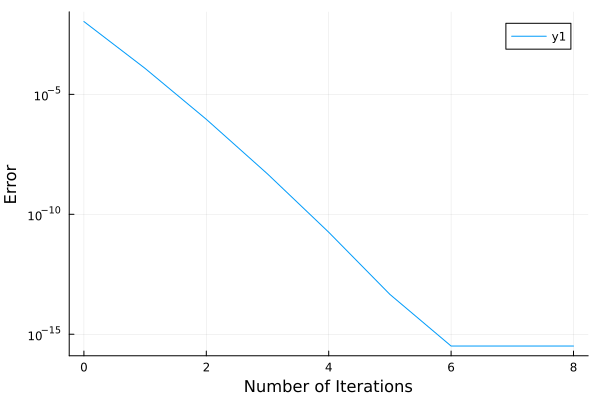

In [25]:
using LinearAlgebra, Plots

u0 = 1.0
a = 0
b = 1.0
lambda=-1.0
f(t, u) = lambda*u
N = 20
Nc=div(N, m)
K = 8 # Number of Iterations
m = 2
err=zeros(K+1)
Uref=Mref(N, m, u0, lambda)
u_store=zeros(Nc+1, K+1)
for k=1:K+1
    u_store[:, k]=Mappr(N, m, u0, lambda, k)
    err[k]= norm(Uref .- u_store[:, k], Inf) .+10^(-16)
end
plot(0:K, err, yaxis=:log, xlabel="Number of Iterations", ylabel="Error")

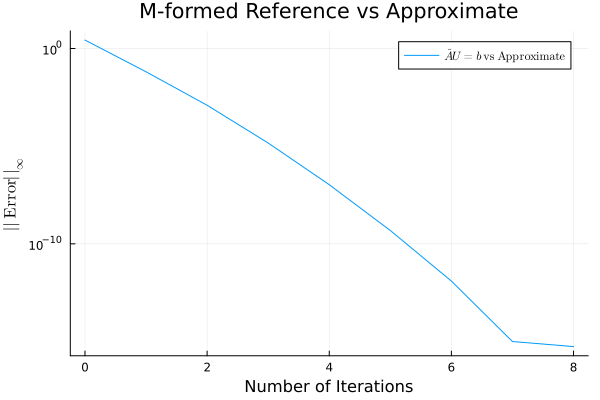

In [31]:
# Comparision with structured matrix form and approximated numerical solution
using LinearAlgebra, Plots, LaTeXStrings

u0 = 1.0
a = 0
b = 1.0
lambda=1.0
f(t, u) = lambda*u
N = 16
K = 8 # Number of Iterations
m = 2
Nc=div(N, m)
err=zeros(K+1)
Uref=Mref(N, m, u0, lambda)
tval, uap=twolevel(f, a, b, N, u0, lambda, m, K)
for k=1:K+1
    err[k]= norm(uap[1 ,1:m:end, k] .- Uref, Inf) .+10^(-16)
end
p3= plot(0:K, err, 
    yaxis=:log, xlabel="Number of Iterations", 
    ylabel=L"||\mathrm{Error}||_\infty",
    title="M-formed Reference vs Approximate", 
    label=L"\tilde{A}U = b \, \mathrm{vs} \, \, \mathrm{Approximate}"
)

savefig("Mapprox_vs_M_ref.png")
# Display the plot
display(p3)

In [ ]:
# Comparision with structured matrix form and approximated numerical solution
using LinearAlgebra, Plots, LaTeXStrings

u0 = 1.0
a = 0
b = 1.0
lambda=1.0
f(t, u) = lambda*u
N = 16
K = 8 # Number of Iterations
m = 2
Nc=div(N, m)
err=zeros(K+1)
ULin=MLin(N, m,u0)
tval, uap=twolevel(f, a, b, N, u0, m, K)
for k=1:K+1
    err[k]= norm(uap[1 ,1:m:end, k] .- ULin, Inf) .+10^(-16)
end
p4= plot(0:K, err, 
    yaxis=:log, xlabel="Number of Iterations", 
    ylabel=L"||\mathrm{Error}||_\infty",
    title="MLin-formed Reference vs Approximate", 
    label=L"\tilde{A}U = b \, \mathrm{vs} \, A u^k = b + L u^{k-1}"
)

savefig("Mapprox_vs_M_ref.png")
# Display the plot
display(p4)